In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
import os

import warnings
warnings.filterwarnings("ignore")


In [2]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import seaborn as sns

In [3]:
train_path='dying_leaves\\train'
valid_path='dying_leaves\\valid'
test_path='dying_leaves\\test'

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    # fill_mode='nearest'
)

In [5]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

Found 80 images belonging to 2 classes.


In [7]:
validation_generator = val_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

Found 17 images belonging to 2 classes.


In [8]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

Found 19 images belonging to 2 classes.


In [9]:
train_generator.class_indices

{'disease': 0, 'natural': 1}

In [20]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [30]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='sigmoid') 
])

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [32]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,571,778 (13.63 MB)

 Trainable params: 1,313,794 (5.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [33]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)

In [34]:
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
class_weight_dict

{0: 0.9523809523809523, 1: 1.0526315789473684}

In [35]:
model.output_shape

(None, 2)

In [36]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    verbose=1,
    restore_best_weights=True

)

In [37]:
train_generator.samples 

80

In [38]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 17s/step - accuracy: 0.7292 - loss: 0.6092 - val_accuracy: 1.0000 - val_loss: 0.0144
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 1.0000 - loss: 0.0215 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 8s/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 7.6514e-04
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 5.5642e-04
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 9s/step - accuracy: 1.0000 - loss: 4.7995e-04 - val_accuracy: 1.0000 - val_loss: 3.3544e-04
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 1.0000 - loss: 1.6341e-05 - val_accuracy: 1.0000 - val_loss: 2.8021e-04
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 9s/step - accuracy: 1.0000 - loss: 1.3696e-05 - val_accuracy: 1.0000 - val_loss: 2.0847e-04
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 1.0000 - loss: 6.2234e-04 - val_accuracy: 1

In [39]:
loss, acc = model.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0323


In [40]:
model.save('model_dying_leaves.h5')

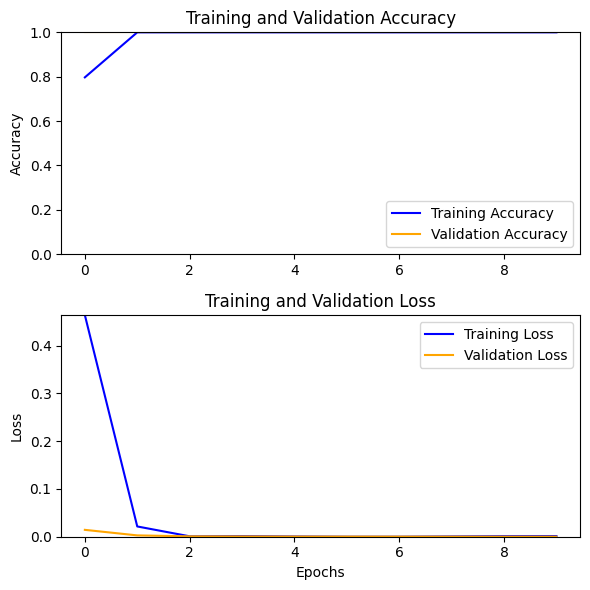

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(6, 6))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])  
plt.title('Training and Validation Accuracy')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0, max(max(loss), max(val_loss))])  
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')


plt.tight_layout()  
plt.show()


In [42]:
true_labels = []
predicted_labels = []

In [43]:
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

In [44]:
class_names

['disease', 'natural']

In [45]:
for class_name in class_names:
    class_path = os.path.join(valid_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array) 

        pred = model.predict(img_array)
        pred_class = np.argmax(pred, axis=1)[0]

        true_labels.append(class_indices[class_name])
        predicted_labels.append(pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


In [46]:
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

     disease       1.00      1.00      1.00         9
     natural       1.00      1.00      1.00         8

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



In [47]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

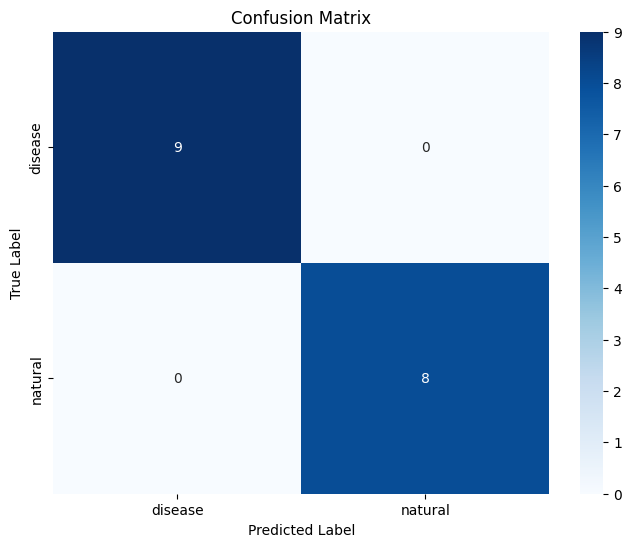

In [48]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()